## Seasonality Analysis

In [1]:
import os
os.chdir(os.environ['PWD'])

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
import re
import string
import boto3
from tqdm import tqdm
from statsmodels.tsa.seasonal import STL

#### Import Historical Data

In [110]:
# Load ENV secrets
# assert load_dotenv(), "Environment file couldnt load"
AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
AWS_SECRET_KEY = os.getenv("AWS_SECRET_KEY")
AWS_BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

# Create an S3 client
s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)

# Load the dataset from S3
objects = s3_client.list_objects_v2(Bucket=AWS_BUCKET_NAME, Prefix = sts.S3_PROJECT_PATH)
pqt_objects = [obj for obj in objects['Contents'] if obj['Key'].endswith('.parquet')]
last_pqt_object = sorted(pqt_objects, key=lambda x: x['LastModified'], reverse=True)[0]

s3_client.download_file(Filename = 'data.parquet', Bucket=AWS_BUCKET_NAME, Key=last_pqt_object['Key'])

In [111]:
dataset = pd.read_parquet('data.parquet')

In [112]:
dataset.groupby(['product'])['market'].nunique().sort_values(ascending=False).head(10)

product
pimenton                35
tomate de arbol         32
cilantro                30
habichuela              30
sal yodada              28
platano harton verde    28
lechuga batavia         27
mora de castilla        27
papa criolla limpia     27
pepino cohombro         26
Name: market, dtype: int64

In [113]:
dataset.groupby(['market'])['product'].nunique().sort_values(ascending=False).head(10)

market
medellin central mayorista de antioquia      147
bogota dc corabastos                         100
villavicencio cav                             91
ibague plaza la 21                            89
bucaramanga centroabastos                     84
manizales centro galerias                     80
barranquilla barranquillita                   80
palmira valle del cauca                       76
monteria mercado del sur                      76
medellin plaza minorista jose maria villa     74
Name: product, dtype: int64

In [114]:
market = 'medellin central mayorista de antioquia'

In [115]:
products = dataset.loc[dataset['market'] == market, 'product'].unique()
print(len(products))

147


In [150]:
product_seas_strenght = {}
for product in tqdm(products):
    price_series = dataset.loc[
        (dataset['product'] == product) & (dataset['market'] == market)
    ].set_index('date').sort_index()['mean_price']
    
    stl = STL(
        price_series, period=12, seasonal_deg=0, trend_deg=1, low_pass_deg=0, robust=True
    )
    res_robust = stl.fit()
    
    seasonal_strenght = max(0, 1 - (res_robust.resid.var() / (res_robust.seasonal+res_robust.resid).var()))
    
    product_seas_strenght[product] = seasonal_strenght

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:03<00:00, 45.05it/s]


In [151]:
sorted(product_seas_strenght.items(), key = lambda x: x[1], reverse = True)[:10]

[('mango tommy', 0.8654711962109054),
 ('aguacate papelillo', 0.7177899644816338),
 ('gulupa', 0.6842579621899221),
 ('maracuya antioqueno', 0.6366413417674797),
 ('uva red globe nacional', 0.6032645847719024),
 ('tomate de arbol', 0.6011427615031286),
 ('pera importada', 0.5945450875434042),
 ('mandarina oneco', 0.574880120315725),
 ('espinaca', 0.5658008886045385),
 ('aguacate hass', 0.5538612332162033)]

In [168]:
product = 'pimenton'

In [169]:
price_series = dataset.loc[
    (dataset['product'] == product) & (dataset['market'] == market)
].set_index('date').sort_index()['mean_price']

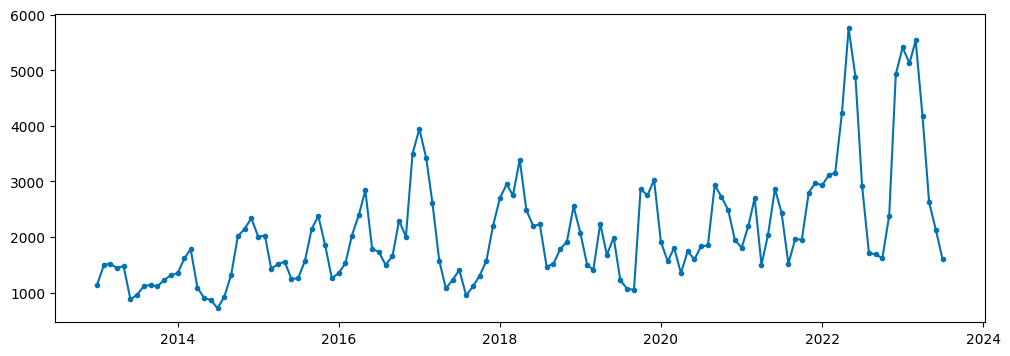

In [170]:
plt.figure(figsize=(12, 4))
plt.plot(price_series, marker = '.')
plt.show()

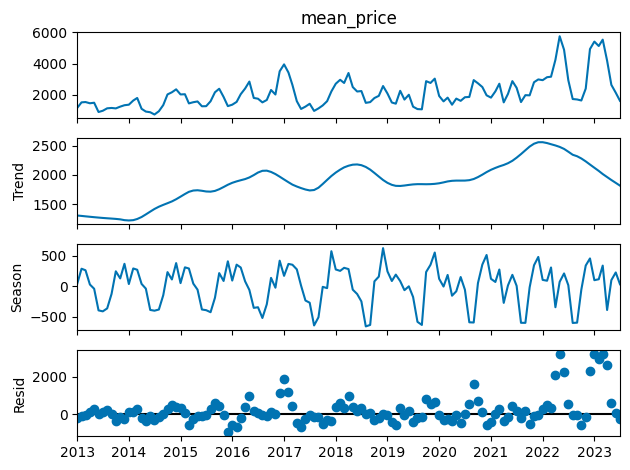

In [171]:
stl = STL(
    price_series, period=12, seasonal_deg=0, trend_deg=1, low_pass_deg=0, robust=True
)
res_robust = stl.fit()
fig = res_robust.plot()

In [172]:
seasonal_strenght = max(0, 1 - (res_robust.resid.var() / (res_robust.seasonal+res_robust.resid).var()))
print(seasonal_strenght)

0.17665339965058335


In [173]:
detrended_series = price_series / res_robust.trend
#detrended_series = res_robust.seasonal / res_robust.trend

In [174]:
detrended_series_df = detrended_series.to_frame()
detrended_series_df.columns = ['price']
detrended_series_df['month'] = detrended_series_df.index.month

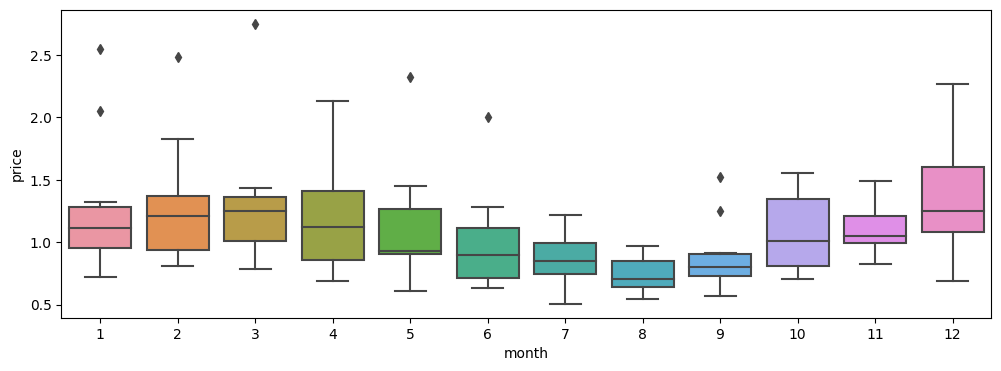

In [175]:
plt.figure(figsize=(12, 4))
sns.boxplot(x = 'month', y = 'price', data = detrended_series_df)
plt.show()